In [39]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 3*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(
                enn.MaskModule(feat_type_in, n_dim, margin=2),
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 12*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=7, padding=0, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        
        feat_type_in  = self.block2.out_type
        feat_type_out = enn.FieldType(r2_act, 3*[r2_act.regular_repr])
        self.block3 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=7, padding=0, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                # enn.MaskModule(feat_type_out, 13, margin=2)
                )
        
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)        
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gpool(x)        
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*3*13*13, 1024)
        self.dense2 = nn.Linear(1024, 256)
        self.dense3 = nn.Linear(256, 64)
        self.dense4 = nn.Linear(64, 1)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.activation(x)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_dim=n_dim,n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x
    

X1=torch.ones(8,2,31,31).to(device)

n_dim=X1.shape[2]
n_channel=X1.shape[1]
s =Siamesa(n_dim=n_dim,n_channel=n_channel).to(device)
s(X1,X1)

tensor([[0.5082],
        [0.5082],
        [0.5082],
        [0.5082],
        [0.5082],
        [0.5082],
        [0.5082],
        [0.5082]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [41]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.5
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    loss = torch.mean(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=0,translate=(0.1,0.1),scale=(0.9,1.1))(x)
    return x


### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [42]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 10
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

Já foi treinado
epoca 100 loss 3.5150668924930053
10 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

pos predict  torch.Size([10, 1, 180, 180]) torch.Size([10, 1, 180, 180])
torch.Size([824, 31, 31]) torch.Size([824, 31, 31]) torch.Size([824, 2, 31, 31])


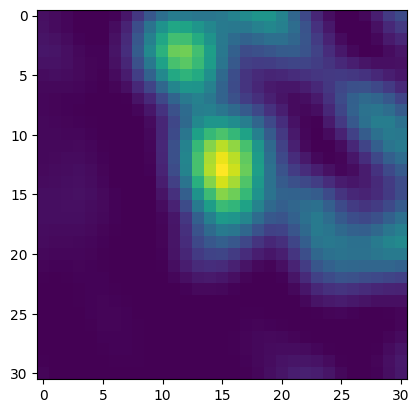

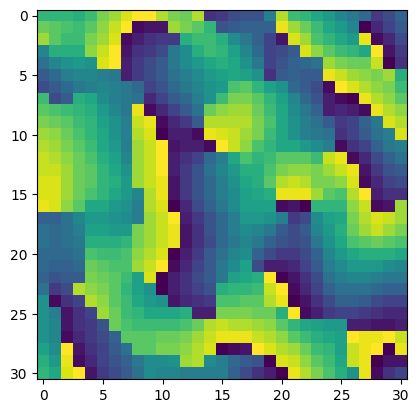

In [43]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

# concatena em um tensor somente as features e orientações
for i,(boxs,mini_feat_batch,mini_orien_batch) in enumerate(batch_result):
    if i==0:
        mini_feat_batch_concat = mini_feat_batch
        mini_orien_batch_concat = mini_orien_batch
    else:
        mini_feat_batch_concat = torch.cat([mini_feat_batch_concat,mini_feat_batch], dim=0)
        mini_orien_batch_concat = torch.cat([mini_orien_batch_concat,mini_orien_batch], dim=0)
    # print('batch ',i,mini_orien_batch_concat.shape)

mini_dataloader = torch.stack([mini_feat_batch_concat,mini_orien_batch_concat], dim=1)
print(mini_feat_batch_concat.shape,mini_orien_batch_concat.shape,mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [44]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 10

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.8
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


66
17


In [45]:

def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        
model =Siamesa(n_dim=31,n_channel=2).to(device)
train(model,train_loader,test_loader,loss_fn,epochs=15,device=device)

Tests : 100%|██████████| 17/17 [00:00<00:00, 27.22it/s]



Epoch: 0, Train Loss: 0.0500, Test Loss: 0.0511


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.64it/s]



Epoch: 1, Train Loss: 0.0483, Test Loss: 0.0488


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.41it/s]



Epoch: 2, Train Loss: 0.0461, Test Loss: 0.0479


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.99it/s]



Epoch: 3, Train Loss: 0.0446, Test Loss: 0.0481


Tests : 100%|██████████| 17/17 [00:00<00:00, 26.62it/s]



Epoch: 4, Train Loss: 0.0454, Test Loss: 0.0464


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.54it/s]



Epoch: 5, Train Loss: 0.0446, Test Loss: 0.0458


Tests : 100%|██████████| 17/17 [00:00<00:00, 27.25it/s]



Epoch: 6, Train Loss: 0.0441, Test Loss: 0.0453


Train :  61%|██████    | 40/66 [00:06<00:03,  6.66it/s]


KeyboardInterrupt: 

### Teste com a rede siamesa

torch.Size([1, 3, 13, 13])
torch.Size([1, 1]) tensor([[0.9609]], device='cuda:0', grad_fn=<SigmoidBackward0>)


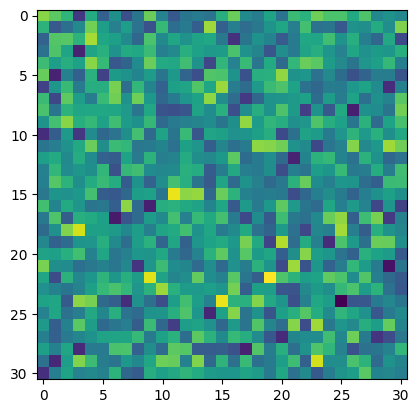

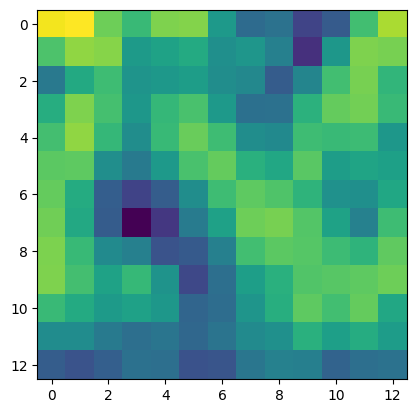

In [ ]:
torch.manual_seed(42)
X = torch.randn(1, 2, 31, 31).to(device)

n_channel=X.shape[1]
n_dim=X.shape[2]

model_feature = model.feature
model_discriminator = model.discriminator
y = model_feature(X)
print(y.shape)
d = model_discriminator(y,y)
print(d.shape,d)
#import
import matplotlib.pyplot as plot
#plot images wrmup
plot.imshow(X[0,0,:,:].cpu().detach().numpy())
plot.show()
plot.imshow(y[0,0,:,:].cpu().detach().numpy())
plot.show()

In [ ]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [ ]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


torch.Size([1, 2, 31, 31]) torch.Size([1, 3, 13, 13])


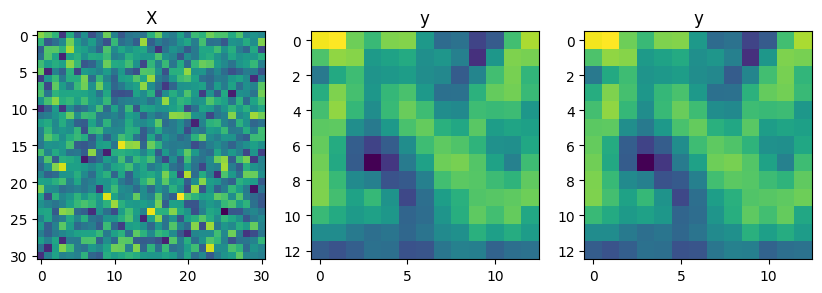

tensor([134., 342., 263., 215.,  56.,  56.,  20., 311., 216., 254.],
       device='cuda:0')
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9484, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(134., device='cuda:0') tensor(-0.0008, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


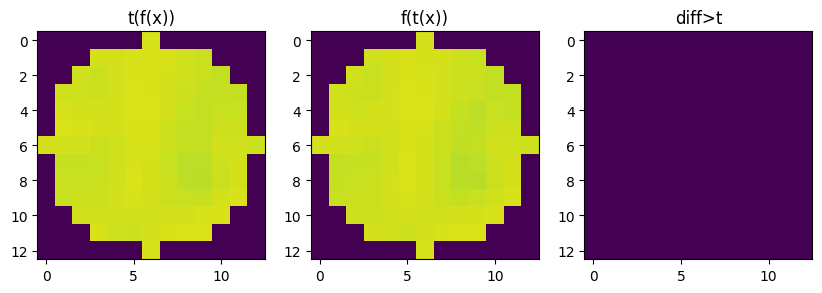

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9470, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(342., device='cuda:0') tensor(-0.0012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


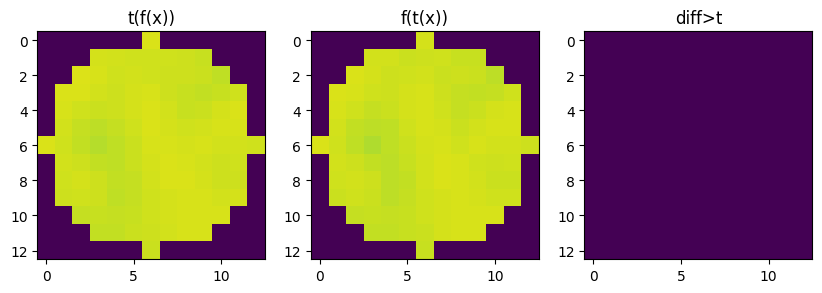

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9444, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(263., device='cuda:0') tensor(-0.0009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


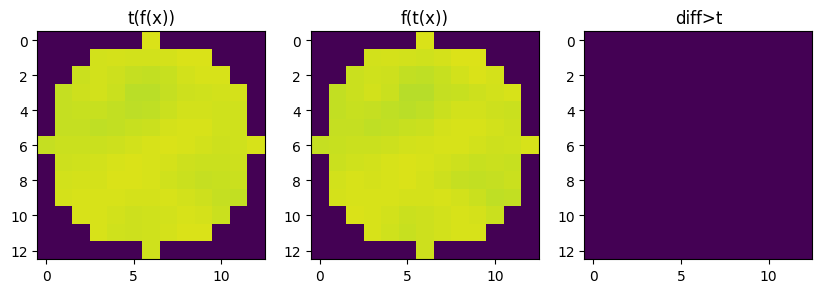

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9447, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(215., device='cuda:0') tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


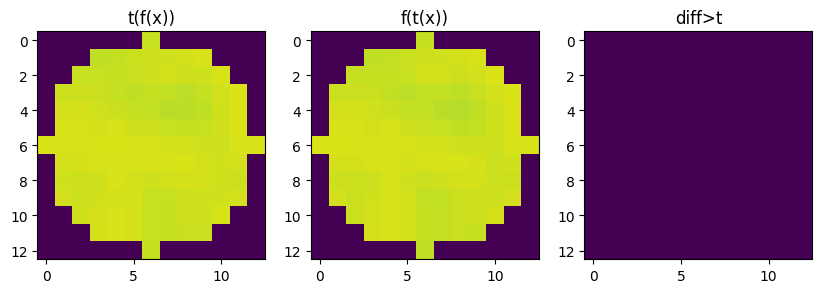

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(56., device='cuda:0') tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


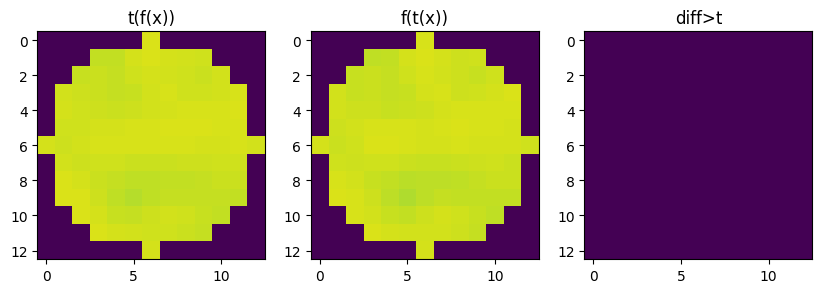

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9453, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(56., device='cuda:0') tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


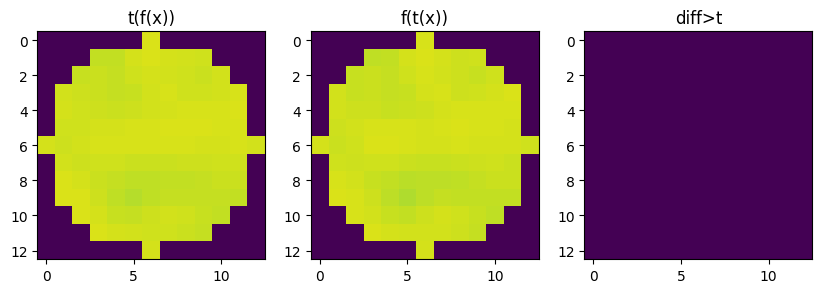

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9441, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(20., device='cuda:0') tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


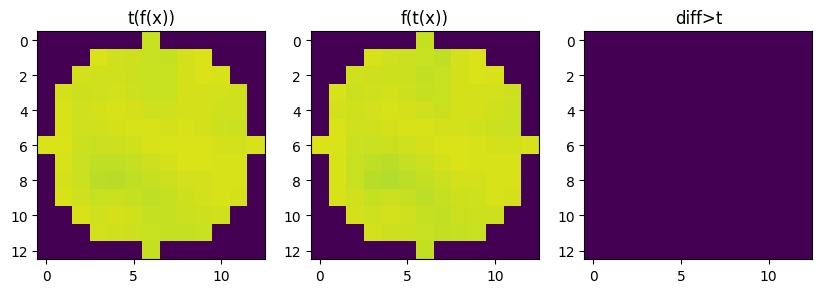

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9465, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(311., device='cuda:0') tensor(-0.0010, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


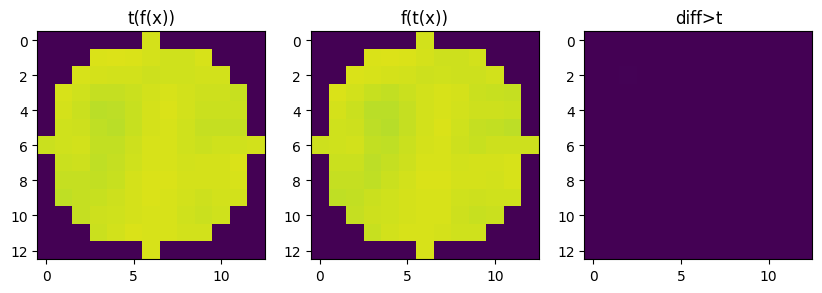

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9445, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(216., device='cuda:0') tensor(-0.0009, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


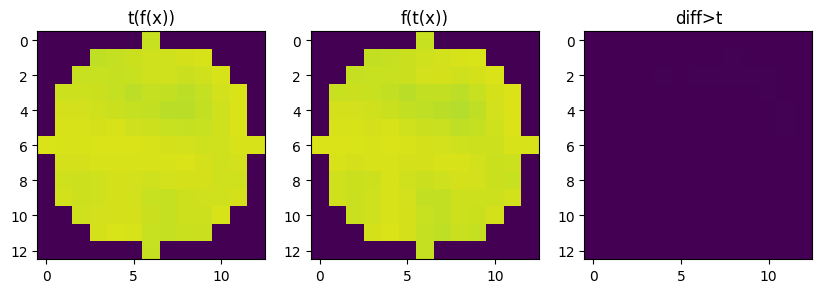

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9467, device='cuda:0', grad_fn=<MaxBackward1>) torch.Size([13, 13])
tensor(254., device='cuda:0') tensor(-0.0012, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)


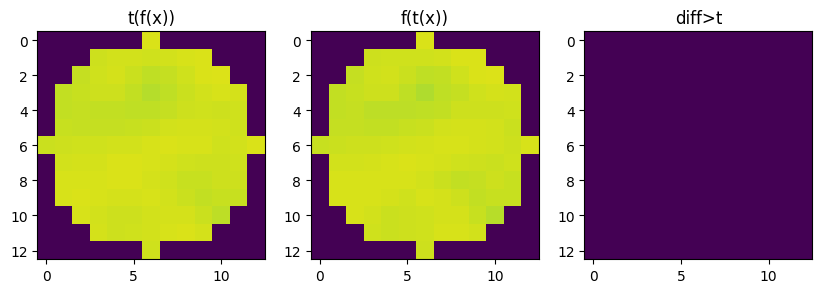

In [ ]:

import math
import numpy as np
from kornia.geometry import transform
from utils import create_circular_mask

torch.manual_seed(42)
np.random.seed(42)
X = torch.randn(1, 2, 31, 31).to(device)
y = model_feature(X)
print(X.shape,y.shape)
show_images(normalize_tensor(X[0,0]),normalize_tensor(y[0,0]),normalize_tensor(y[0,0]),title1="X",title2="y",title3="y")
#gerar um vetor de angulos aleatorios
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)
print(angles)
c_mask = create_circular_mask(y.shape[2],y.shape[3])
c_mask = torch.tensor(c_mask).to(device)
for angle in angles:
    Xt,yt = rotate_images(X,y,angle)
    
    yt = yt*c_mask
    #rotacionar a imagem
    y2 = model_feature(Xt)*c_mask

    show_images(normalize_tensor(X[0,0]),normalize_tensor(y[0,0]),normalize_tensor(y[0,0]),title1="X",title2="y",title3="y")
    #normalizar as imagens
    # y1n=normalize_tensor(yt[0,0])
    # y2n=normalize_tensor(y2[0,0])
    y1n=yt[0,0]
    y2n=y2[0,0]
    
    diff = y2n - y1n
    t = 0.001
    diff[abs(diff) < t] = 0
    print(y1n.min(),y1n.max(),y1n.shape)
    print(angle,diff.mean(),diff[0,0])
    show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

    
    # check if the two are equal up to a certain tolerance
    # assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g